In [1]:
import crypten
import torch
import numpy as np
import matplotlib.pyplot as plt

import crypten.mpc as mpc
import crypten.communicator as comm 

crypten.init()

torch.set_num_threads(1)
torch.set_printoptions(precision=10)

In [2]:
def sample_dataset(n, p, c, k):
    np.random.seed(0)
    x = np.random.uniform(-1, 1, (n, p))
    noise = np.random.uniform(-c, c, n)
    
    theta_star = np.random.uniform(-1, 1, p)

    # make theta_star k-sparse randomly
    index = np.random.choice(range(p), k)
    for i in index:
        theta_star[i] = 0
        
    y = x @ theta_star + noise
    return torch.tensor(x), torch.tensor(y), torch.tensor(theta_star)

In [3]:
@mpc.run_multiprocess(world_size=3)
def proba():

    x = torch.tensor([[1, 0, 1, 0], [0, 0, 1, 1], [1, 1, 1, 1]])
    y = torch.tensor([1, 2, 3])

    x_enc = crypten.cryptensor(x, ptype=crypten.mpc.arithmetic)
    y_enc = crypten.cryptensor(y, ptype=crypten.mpc.arithmetic)
    

    # bits cutting
    z = torch.tensor([100, 200, 300])
    z_enc = crypten.cryptensor(z, ptype=crypten.mpc.arithmetic)

    z_enc_trunc = crypten.cryptensor(torch.zeros(3), ptype=crypten.mpc.arithmetic)
    for i in range(3):
        z_enc_trunc[i] = z_enc[i].div(2)

    crypten.print(f"Source {0} secret after trucation: {z_enc.get_plain_text()} -> {z_enc_trunc.get_plain_text()}")

    # SUM
    x_enc_summed = x_enc.sum(dim=1) # dim=1 for column, or dim = 0 to do it by rows
    x_summed_revealed = x_enc_summed.get_plain_text()

    crypten.print(f"Source {0} for x_summed_revealed: {x_summed_revealed}")

    # NORM
    x_enc_mult = x_enc_summed.matmul(y)
    x_mult_revealed = x_enc_mult.get_plain_text()

    crypten.print(f"Source {0} for mult for same size (norm): {x_mult_revealed}")

    # TRANSPOSE
    y_enc_t = y_enc.transpose(-1, 0)
    crypten.print(f"Source {0} transpose: {y_enc.shape} -> {y_enc_t.shape}")

    x_enc_t = x_enc.transpose(0, -1)
    crypten.print(f"Source {0} transpose: {x_enc.shape} -> {x_enc_t.shape}")

    # NORM
    x_enc_mult2 = x_enc.transpose(0, 1).matmul(y)
    x_mult_revealed2 = x_enc_mult2.get_plain_text()
    crypten.print(f"Source {0} for mult for different sizes: {x_mult_revealed2}")


    

In [4]:
proba();

Source 0 secret after trucation: tensor([100., 200., 300.]) -> tensor([ 50.0000000000, 100.0000000000, 149.9999847412])
Source 0 for x_summed_revealed: tensor([2., 2., 4.])
Source 0 for mult for same size (norm): 18.0
Source 0 transpose: torch.Size([3]) -> torch.Size([3])
Source 0 transpose: torch.Size([3, 4]) -> torch.Size([4, 3])
Source 0 for mult for different sizes: tensor([4., 3., 6., 5.])


In [5]:
nabla_prev = torch.zeros(10)
nabla_prev[5] = 17
nabla_prev

tensor([ 0.,  0.,  0.,  0.,  0., 17.,  0.,  0.,  0.,  0.])

In [6]:
x = torch.tensor([[1, 0, 1, 0], [0, 0, 1, 1], [1, 1, 0, 0]]) # n = 3, p = 4
theta_star = torch.tensor([1, 2, 3, 4])
noise = torch.tensor([1, 1, 1])
y = x.matmul(theta_star) + noise

y

tensor([5, 8, 4])

In [7]:
x = x.int()
theta_star = theta_star.int()
noise = noise.int()

y = x.matmul(theta_star) + noise

y

tensor([5, 8, 4], dtype=torch.int32)

In [8]:
## for debugging
def reveal_and_print(x, info_text=''):
    x_rev = x.get_plain_text()
    crypten.print(f"Source {0} {info_text}= {x_rev}")

In [9]:
# for truncation step
# make a vector v k-sparse, meaning that only the largest k values are non-zero
# select the smallest (n - k) values, and make them zero

def truncate_mpc(x, k, bits_to_cut):
    x_copy = x.clone() # to avoid cutting bits on the real input, which is returned at the end

    n = len(x)
    if k == 0 or k == n:
        return x # no change needed
    
    # preparing for argmax:
    # cutting c bits for efficiency reasons
    if bits_to_cut > 0:
        x_copy = x_copy.div(bits_to_cut) # removing the last c=6 bits from every share

    x_copy_abs = x_copy.abs()
    max_value = x_copy_abs.max()
    argmin_index_rev = []
    k = n - k

    for _ in range(k):
        min_index = x_copy_abs.argmin(one_hot=False)

        min_index_rev = min_index.get_plain_text()
        x_copy_abs[min_index_rev] = max_value # set to the maximum value to avoid finding the same index in the next iteration

        argmin_index_rev.append(min_index_rev)

    # set all min index to 0 for x (not for x_copy)
    for i in argmin_index_rev:
        x[i] = crypten.cryptensor(0, ptype=crypten.mpc.arithmetic)
    return x

In [10]:
# testing
x_input = [-100, 1, 2, 3, 4, 5, 6, 7]
x_input_enc = crypten.cryptensor(x_input, ptype=crypten.mpc.arithmetic)
sparse_x = truncate_mpc(x_input_enc, 3)
sparse_x.get_plain_text()

tensor([-100.,    0.,    0.,    0.,    0.,    0.,    6.,    7.])

In [26]:
@mpc.run_multiprocess(world_size=3)
def iht_mpc(n, p, k, T, eta=0.1, c=0.05, bits_to_cut=1):

    x_input, y_input, theta_star = sample_dataset(n, p, c, k)

    #x_input = torch.tensor([[1, 0, 1, 0], [0, 0, 1, 1], [1, 1, 0, 0]]) # n = 3, p = 4
    #theta_star_input = torch.tensor([1, 2, 3, 4])
    #noise_input = torch.tensor([1, 1, 1])
    #y_input = x_input.matmul(theta_star_input) + noise_input

    ### All the variables from here on are in shared format, the result of computations is also in shared format
    ### Only eta and n, both constants, are not in shared format.

    # distribute the input
    x = crypten.cryptensor(x_input, ptype=crypten.mpc.arithmetic)
    y = crypten.cryptensor(y_input, ptype=crypten.mpc.arithmetic)
    theta_prev = crypten.cryptensor(torch.zeros(p), ptype=crypten.mpc.arithmetic)

    iterations_error_enc = crypten.cryptensor(torch.zeros(T), ptype=crypten.mpc.arithmetic)

    # Line 3
    for t in range(T):
        nablas_sum = 0 # this will do matrix addition column-wise

        for i in range(n):
            a = theta_prev.matmul(x[i]) # --> scalar
            a = a - y[i] # --> scalar
            b = x[i].transpose(0, -1)
            nabla_i = b.mul(a)

            nablas_sum += nabla_i
        
        # Line 4: aggregate gradients
        nabla_prev = nablas_sum.div(n)

        # Line 5: perform gradient descend
        theta_t = theta_prev - eta * nabla_prev

        # Line 6: add sparsity
        theta_t = truncate_mpc(theta_t, k, bits_to_cut)

        # compute iteration error
        e = theta_t - theta_star
        e = e.norm(p=2)
        iterations_error_enc[t] = e

        # update theta for next iteration
        theta_prev = theta_t

        crypten.print(f"Source {0} Iteration {t} done.")

    iterations_error_reveal = iterations_error_enc.get_plain_text()
    return iterations_error_reveal


### Plots 1: error by iteration

- ox: iteration number
- oy: error || theta_star - theta_t||2
- varied by k (sparsity)

In [12]:
def plot_error_by_iterations(results):
    _, axs = plt.subplots(2, 2, figsize=(14, 10))

    r, c = 0, 0
    for k in [5, 10, 20, 30]:
        for key in results.keys():
            if key[1] == k:
                T = len(results[key][0])
                n, k = key
                axs[r, c].plot(range(T), results[key][0].numpy(), label=f'n={n}',
                         color=(np.random.random(), np.random.random(), np.random.random()))

        axs[r, c].set_title(f'p = {64}, k = {k}')
        axs[r, c].legend(loc=1)
        
        c += 1
        if c == 2:
            c = 0
            r += 1

    for ax in axs.flat:
        ax.set(xlabel='T (iterations)', ylabel='||theta_t - theta*||2')
        
    plt.show()

In [27]:
# Note: didn't do 10 runs here 
k_values = [5]
n_values = [1, 5, 10]
p = 64
results = {}

for k in k_values:
    for n in n_values:
        thetas = iht_mpc(int(n * (10 ** 3)), p, k, T=10, bits_to_cut=0)
        results[(n, k)] = thetas
        print(f'done with n={n} k={k}')

Source 0 Iteration 0 done.
Source 0 Iteration 1 done.
Source 0 Iteration 2 done.
Source 0 Iteration 3 done.
Source 0 Iteration 4 done.
Source 0 Iteration 5 done.
Source 0 Iteration 6 done.
Source 0 Iteration 7 done.
Source 0 Iteration 8 done.
Source 0 Iteration 9 done.
done with n=1 k=5
Source 0 Iteration 0 done.
Source 0 Iteration 1 done.
Source 0 Iteration 2 done.
Source 0 Iteration 3 done.
Source 0 Iteration 4 done.
Source 0 Iteration 5 done.
Source 0 Iteration 6 done.
Source 0 Iteration 7 done.
Source 0 Iteration 8 done.
Source 0 Iteration 9 done.
done with n=5 k=5
Source 0 Iteration 0 done.
Source 0 Iteration 1 done.
Source 0 Iteration 2 done.
Source 0 Iteration 3 done.
Source 0 Iteration 4 done.
Source 0 Iteration 5 done.
Source 0 Iteration 6 done.
Source 0 Iteration 7 done.
Source 0 Iteration 8 done.
Source 0 Iteration 9 done.
done with n=10 k=5


In [31]:
k_values = [5]
n_values = [1, 5, 10]
p = 64
results2 = {}

for k in k_values:
    for n in n_values:
        thetas = iht_mpc(int(n * (10 ** 3)), p, k, T=10, bits_to_cut=2) # division by 2
        results2[(n, k)] = thetas
        print(f'done with n={n} k={k}')

Source 0 Iteration 0 done.
Source 0 Iteration 1 done.
Source 0 Iteration 2 done.
Source 0 Iteration 3 done.
Source 0 Iteration 4 done.
Source 0 Iteration 5 done.
Source 0 Iteration 6 done.
Source 0 Iteration 7 done.
Source 0 Iteration 8 done.
Source 0 Iteration 9 done.
done with n=1 k=5
Source 0 Iteration 0 done.
Source 0 Iteration 1 done.
Source 0 Iteration 2 done.
Source 0 Iteration 3 done.
Source 0 Iteration 4 done.
Source 0 Iteration 5 done.
Source 0 Iteration 6 done.
Source 0 Iteration 7 done.
Source 0 Iteration 8 done.
Source 0 Iteration 9 done.
done with n=5 k=5
Source 0 Iteration 0 done.
Source 0 Iteration 1 done.
Source 0 Iteration 2 done.
Source 0 Iteration 3 done.
Source 0 Iteration 4 done.
Source 0 Iteration 5 done.
Source 0 Iteration 6 done.
Source 0 Iteration 7 done.
Source 0 Iteration 8 done.
Source 0 Iteration 9 done.
done with n=10 k=5


In [32]:
results2
#torch.save(results, 'plot_1.pt') # key - (n, k); value: errors from all iterations

{(1,
  5): [tensor([4.0698394775, 4.0614166260, 4.0571441650, 4.0554656982, 4.0542755127,
          4.0538787842, 4.0538940430, 4.0542449951, 4.0533599854, 4.0545959473]), tensor([4.0698394775, 4.0614166260, 4.0571441650, 4.0554656982, 4.0542755127,
          4.0538787842, 4.0538940430, 4.0542449951, 4.0533599854, 4.0545959473]), tensor([4.0698394775, 4.0614166260, 4.0571441650, 4.0554656982, 4.0542755127,
          4.0538787842, 4.0538940430, 4.0542449951, 4.0533599854, 4.0545959473])],
 (5,
  5): [tensor([4.3280181885, 4.3201141357, 4.3156280518, 4.3136596680, 4.3132934570,
          4.3127288818, 4.3125457764, 4.3117980957, 4.3114471436, 4.3117065430]), tensor([4.3280181885, 4.3201141357, 4.3156280518, 4.3136596680, 4.3132934570,
          4.3127288818, 4.3125457764, 4.3117980957, 4.3114471436, 4.3117065430]), tensor([4.3280181885, 4.3201141357, 4.3156280518, 4.3136596680, 4.3132934570,
          4.3127288818, 4.3125457764, 4.3117980957, 4.3114471436, 4.3117065430])],
 (10,
  5): [t

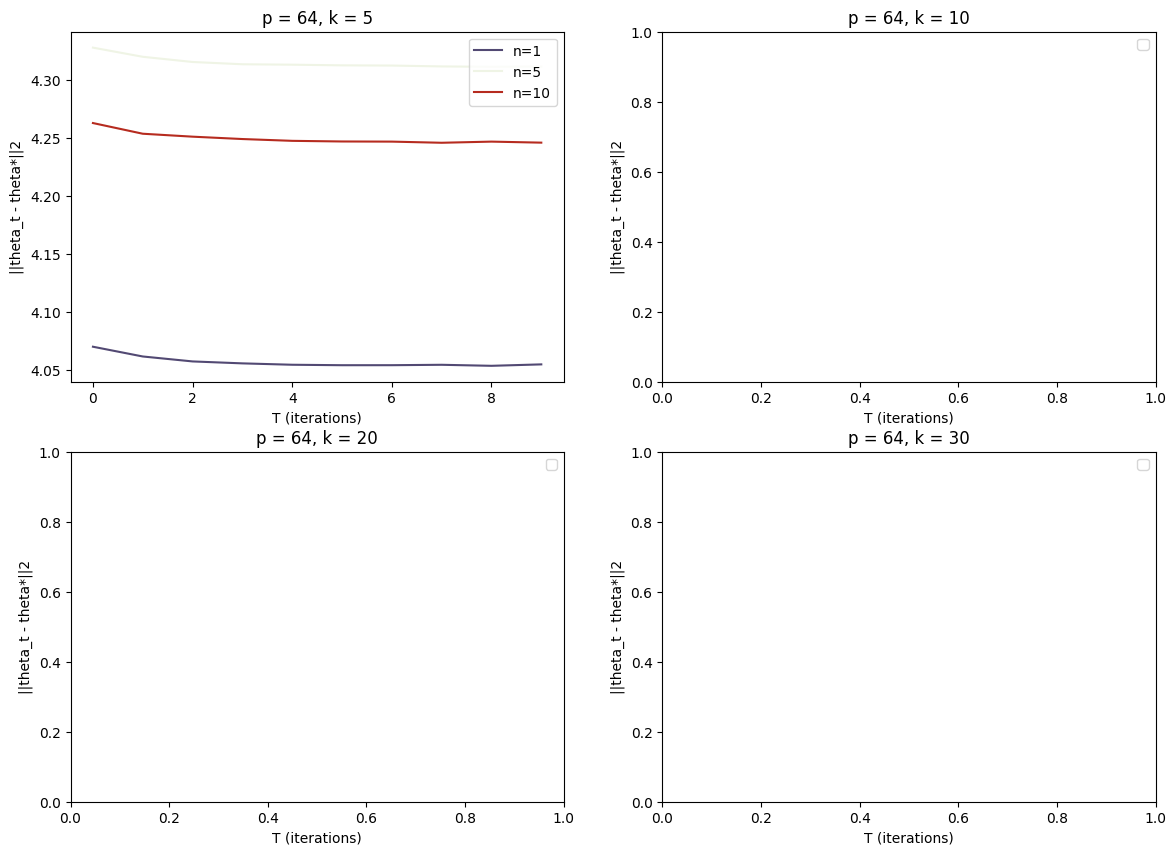

In [35]:
plot_error_by_iterations(results2)

In [48]:
results

{(1,
  5): [tensor([4.0173492432, 3.9362945557, 3.8721160889, 3.8190307617, 3.7767791748,
          3.7437591553, 3.7172241211, 3.6959686279, 3.6803436279, 3.6664276123]), tensor([4.0173492432, 3.9362945557, 3.8721160889, 3.8190307617, 3.7767791748,
          3.7437591553, 3.7172241211, 3.6959686279, 3.6803436279, 3.6664276123]), tensor([4.0173492432, 3.9362945557, 3.8721160889, 3.8190307617, 3.7767791748,
          3.7437591553, 3.7172241211, 3.6959686279, 3.6803436279, 3.6664276123])],
 (5,
  5): [tensor([4.5921020508, 4.5198822021, 4.4608154297, 4.4140167236, 4.3768157959,
          4.3480377197, 4.3226318359, 4.3043975830, 4.2885742188, 4.2753448486]), tensor([4.5921020508, 4.5198822021, 4.4608154297, 4.4140167236, 4.3768157959,
          4.3480377197, 4.3226318359, 4.3043975830, 4.2885742188, 4.2753448486]), tensor([4.5921020508, 4.5198822021, 4.4608154297, 4.4140167236, 4.3768157959,
          4.3480377197, 4.3226318359, 4.3043975830, 4.2885742188, 4.2753448486])],
 (10,
  5): [t

## Plot

- ox: varying n
- oy: error
- by k

{5: [3.6664276, 4.275345, 4.0262756], 10: [2.9668274, 3.6322937, 3.436432], 20: [1.7776184, 2.6289215, 1.8852997]}


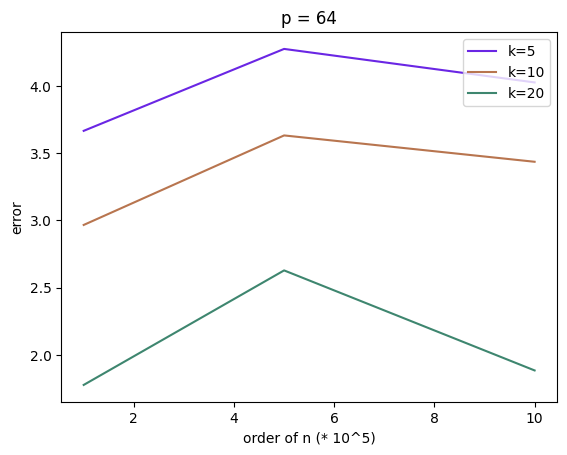

In [59]:
y_values = {}
for key in results.keys():
    n, k = key
    
    if k not in y_values:
        y_values[k] = []
    
    y_values[k].append(results[key][0].numpy()[-1])

print(y_values)

for k in y_values.keys():
    plt.plot(n_values, y_values[k], label=f'k={k}', color=(np.random.random(), np.random.random(), np.random.random()))

plt.legend(loc=1)
plt.xlabel("order of n (* 10^5)")
plt.ylabel("error")
plt.title("p = 64")
plt.show()